In [1]:
import numpy as np
import pandas as pd

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# split data
from sklearn.model_selection import train_test_split

# label encoder
from sklearn.preprocessing import LabelEncoder

# to make metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

# Pre processing data

In [2]:
train = pd.read_csv("/kaggle/input/mqttset/train70_augmented.csv")
test = pd.read_csv("/kaggle/input/mqttset/test30_augmented.csv")

# transform to df
train = pd.DataFrame(train)
test = pd.DataFrame(test)

# data shape
print("Train shape: ", train.shape)
print("Test shape: ", test.shape, "\n")

print("Train target:\n", train['target'].value_counts())
print("Test target:\n",test['target'].value_counts())

Train shape:  (14000000, 34)
Test shape:  (6000000, 34) 

Train target:
 target
legitimate    7000000
bruteforce    1400000
flood         1400000
slowite       1400000
dos           1400000
malformed     1400000
Name: count, dtype: int64
Test target:
 target
legitimate    3000000
dos            600000
slowite        600000
flood          600000
bruteforce     600000
malformed      600000
Name: count, dtype: int64


In [3]:
# features countais only values equal to 0
print(train['mqtt.conack.flags.reserved'].unique())
print(train['mqtt.conack.flags.sp'].unique())
print(train['mqtt.conflag.qos'].unique())
print(train['mqtt.conflag.reserved'].unique())
print(train['mqtt.conflag.retain'].unique())
print(train['mqtt.conflag.willflag'].unique())
print(train['mqtt.sub.qos'].unique())
print(train['mqtt.suback.qos'].unique())
print(train['mqtt.willmsg'].unique())
print(train['mqtt.willmsg_len'].unique())
print(train['mqtt.willtopic'].unique())
print(train['mqtt.willtopic_len'].unique())

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [4]:
# columns_0 are columns with values equal to 0
columns_0 = ['mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conflag.qos',
           'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.willflag',
           'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.willmsg', 'mqtt.willmsg_len',
           'mqtt.willtopic', 'mqtt.willtopic_len']

train = train.drop(columns_0, axis=1)
test = test.drop(columns_0, axis=1)

# new data shape
print(train.shape)
print(test.shape)

(14000000, 22)
(6000000, 22)


In [5]:
# data balancing
# the balancing is done depending of the class

# ===========================================================

# to train data

bruteforce = []
#dos = []
flood = []
legitimate = []
malformed = []
slowite = []

for i in train.index:

    if train['target'][i] == 'bruteforce':
        bruteforce.append(i)
    
#     if train['target'][i] == 'dos':
#         dos.append(i)
    
    if train['target'][i] == 'flood':
        flood.append(i)
        
    if train['target'][i] == 'legitimate':
        legitimate.append(i)
        
    if train['target'][i] == 'malformed':
        malformed.append(i)
        
    if train['target'][i] == 'slowite':
        slowite.append(i)
        
bruteforce = bruteforce[:1120000]
#dos = dos[:1120000]
flood = flood[:1120000]
legitimate = legitimate[:6720000]
malformed = malformed[:1120000]
slowite = slowite[:1120000]

# drop lines to balance data
train = train.drop(bruteforce)
#train = train.drop(dos)
train = train.drop(flood)
train = train.drop(legitimate)
train = train.drop(malformed)
train = train.drop(slowite)

# =================================================================================

# to test data

bruteforce = []
#dos = []
flood = []
legitimate = []
malformed = []
slowite = []

for i in test.index:

    if test['target'][i] == 'bruteforce':
        bruteforce.append(i)
    
#     if test['target'][i] == 'dos':
#         dos.append(i)
    
    if test['target'][i] == 'flood':
        flood.append(i)
        
    if test['target'][i] == 'legitimate':
        legitimate.append(i)
        
    if test['target'][i] == 'malformed':
        malformed.append(i)
        
    if test['target'][i] == 'slowite':
        slowite.append(i)
        
bruteforce = bruteforce[:480000]
#dos = dos[:480000]
flood = flood[:480000]
legitimate = legitimate[:2880000]
malformed = malformed[:480000]
slowite = slowite[:480000]

# drop lines
test = test.drop(bruteforce)
#test = test.drop(dos)
test = test.drop(flood)
test = test.drop(legitimate)
test = test.drop(malformed)
test = test.drop(slowite)

# ================================================================================

# new target size
print("Train: ")
print(train['target'].value_counts())
print("\n")
print("Test: ")
print(test['target'].value_counts())

Train: 
target
dos           1400000
slowite        280000
bruteforce     280000
flood          280000
malformed      280000
legitimate     280000
Name: count, dtype: int64


Test: 
target
dos           600000
slowite       120000
flood         120000
malformed     120000
bruteforce    120000
legitimate    120000
Name: count, dtype: int64


In [7]:
# transform dataframe in two unique classes

for i in train.index:
    if train['target'][i] != 'dos':
        train.at[i, 'target'] = 'other'
        
for i in test.index:
    if test['target'][i] != 'dos':
        test.at[i, 'target'] = 'other'
        
# new dataframe
print(train['target'].value_counts())
print(test['target'].value_counts())

target
dos      1400000
other    1400000
Name: count, dtype: int64
target
dos      600000
other    600000
Name: count, dtype: int64


In [8]:
# data concatenation

data = pd.concat([train, test], ignore_index=True)

print(data.shape)
print("\n")
print(data['target'].value_counts())

(4000000, 22)


target
dos      2000000
other    2000000
Name: count, dtype: int64


In [9]:
# separation features and targets
X = data.iloc[:,:-1]
y = data['target']

In [10]:
# encoder cateagorical features
label = LabelEncoder()

X['tcp.flags'] = label.fit_transform(X['tcp.flags'])
X['mqtt.conack.flags'] = label.fit_transform(X['mqtt.conack.flags'])
X['mqtt.hdrflags'] = label.fit_transform(X['mqtt.hdrflags'])
X['mqtt.protoname'] = label.fit_transform(X['mqtt.protoname'])
X['mqtt.msg'] = label.fit_transform(X['mqtt.msg'])
X['mqtt.conflags'] = label.fit_transform(X['mqtt.conflags'])
y = label.fit_transform(y)

In [11]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [12]:
# convert to numpy
X_train = X_train.values
X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

print(type(X_test))

<class 'numpy.ndarray'>


# DT

Accuracy train:  0.9413298507462686

Cross-validation scores: [0.94126493 0.94126679 0.94104851 0.9412444  0.94155037]

Average cross-validation score: 0.94 



Accuracy test:  0.9410901515151515 



Classification report: 

              precision    recall  f1-score   support



           0       0.96      0.92      0.94    660161

           1       0.93      0.96      0.94    659839



    accuracy                           0.94   1320000

   macro avg       0.94      0.94      0.94   1320000

weighted avg       0.94      0.94      0.94   1320000

 



Confusion matrix: 

 [[609860  50301]

 [ 27460 632379]] 




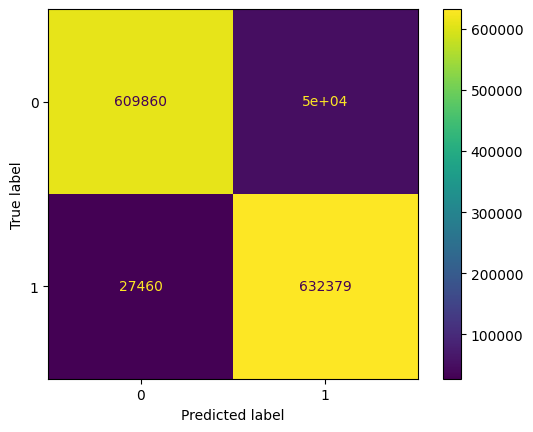

In [14]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

print("Accuracy train: ", tree.score(X_train, y_train))

# cross validation
scores = cross_val_score(tree, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()),"\n")
print("Accuracy test: ", tree.score(X_test, y_test), "\n")

# classification report
predict_tree = tree.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_tree), "\n")

# confusion matrix
matrix_tree = confusion_matrix(y_test, predict_tree)
print("Confusion matrix: \n",matrix_tree, "\n")
cm_tree = confusion_matrix(y_test, predict_tree, labels=tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=tree.classes_)
disp_tree.plot()
plt.show()

# RF

Accuracy train:  0.9413298507462686

Cross-validation scores: [0.94127425 0.94126679 0.94106157 0.9412444  0.94155784]

Average cross-validation score: 0.94 



Accuracy test:  0.9410878787878788 



Classification report: 

              precision    recall  f1-score   support



           0       0.96      0.92      0.94    660161

           1       0.93      0.96      0.94    659839



    accuracy                           0.94   1320000

   macro avg       0.94      0.94      0.94   1320000

weighted avg       0.94      0.94      0.94   1320000

 



Confusion matrix:

 [[609841  50320]

 [ 27444 632395]] 




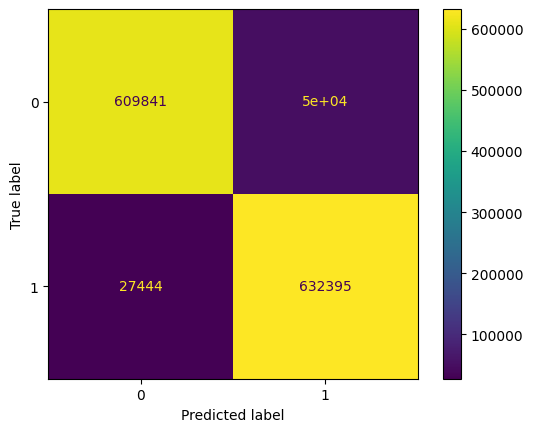

In [15]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Accuracy train: ", rf.score(X_train, y_train))

# cross validation
scores_rf = cross_val_score(rf, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores_rf))
print("Average cross-validation score: {:.2f}".format(scores_rf.mean()),"\n")

print("Accuracy test: ", rf.score(X_test, y_test), "\n")


# classification report
predict_rf = rf.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_rf), "\n")

# confusion matrix
matrix_rf = confusion_matrix(y_test, predict_rf)
print("Confusion matrix:\n", matrix_rf, "\n")
cm_rf = confusion_matrix(y_test, predict_rf, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp_rf.plot()
plt.show()

# XGB

Accuracy train:  0.9400324626865671

Cross-validation scores: [0.94001119 0.93983022 0.93981903 0.93996082 0.9403041 ]

Average cross-validation score: 0.94 



Accuracy test:  0.9398409090909091 



Classification report: 

              precision    recall  f1-score   support



           0       0.96      0.92      0.94    660161

           1       0.92      0.96      0.94    659839



    accuracy                           0.94   1320000

   macro avg       0.94      0.94      0.94   1320000

weighted avg       0.94      0.94      0.94   1320000

 



Confusion matrix:

 [[608189  51972]

 [ 27438 632401]] 




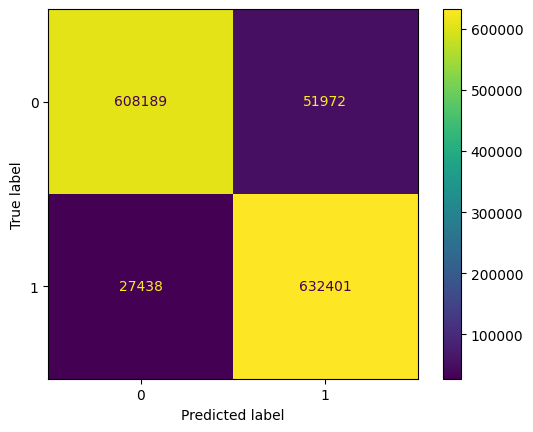

In [16]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

print("Accuracy train: ", xgb.score(X_train, y_train))

# cross validation
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores_xgb))
print("Average cross-validation score: {:.2f}".format(scores_xgb.mean()),"\n")

print("Accuracy test: ", xgb.score(X_test, y_test), "\n")


# classification report
predict_xgb = xgb.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_xgb), "\n")

# confusion matrix
matrix_xgb = confusion_matrix(y_test, predict_xgb)
print("Confusion matrix:\n", matrix_xgb, "\n")
cm_xgb = confusion_matrix(y_test, predict_xgb, labels=xgb.classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb.classes_)
disp_xgb.plot()
plt.show()

# ADA

Accuracy train:  0.9391138059701493
Cross-validation scores: [0.93903172 0.93903731 0.93899254 0.93905224 0.93947201]
Average cross-validation score: 0.94 

Accuracy test:  0.9389727272727273 

Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.92      0.94    660161
           1       0.92      0.96      0.94    659839

    accuracy                           0.94   1320000
   macro avg       0.94      0.94      0.94   1320000
weighted avg       0.94      0.94      0.94   1320000
 

Confusion matrix:
 [[606824  53337]
 [ 27219 632620]] 



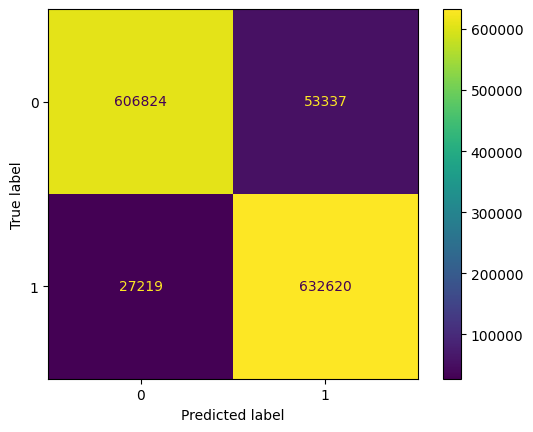

In [16]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

print("Accuracy train: ", ada.score(X_train, y_train))

# cross validation
scores_ada = cross_val_score(ada, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores_ada))
print("Average cross-validation score: {:.2f}".format(scores_ada.mean()),"\n")

print("Accuracy test: ", ada.score(X_test, y_test), "\n")


# classification report
predict_ada = ada.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_ada), "\n")

# confusion matrix
matrix_ada = confusion_matrix(y_test, predict_ada)
print("Confusion matrix:\n", matrix_ada, "\n")
cm_ada = confusion_matrix(y_test, predict_ada, labels=ada.classes_)
disp_ada = ConfusionMatrixDisplay(confusion_matrix=cm_ada, display_labels=ada.classes_)
disp_ada.plot()
plt.show()